In [1]:
!pip install langchain langgraph cassio

In [2]:
!pip install langchain_community

In [3]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [4]:
import cassio
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:DHXHpyDSDzDEJgnCEmpMvMhU:bcabbd14b419dce9d8617a4408d370ac37be10d33c26720664744cc7956012a0"
ASTRA_DB_ID = "4d0ac63c-db4d-4461-a30b-5654bec200c2"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [5]:
# Import necessary libraries
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# Step 1: Load and split documents
urls = [
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
# print(docs_list)
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [22]:
# !pip install pypdf

# Import necessary libraries
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

# Step 1: Load and split PDF documents
pdf_path = r"C:\Users\pavan\Downloads\what-is-air-pollution-2019.pdf"  # Replace with the path to your PDF

# Load the PDF
loader = PyPDFLoader(pdf_path)
docs = loader.load()

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs)

# Now you have the PDF content split into chunks
# You can print or process it further
print(doc_splits)


[Document(metadata={'source': 'C:\\Users\\pavan\\Downloads\\what-is-air-pollution-2019.pdf', 'page': 0}, page_content='FACT SHEET 1  \nWhat is Air Pollution? \nWhat is air pollution? \n\uf0b7Air pollution is the contamination of the\nindoor or outdoor air by a range of\ngasses and solids that modify its\nnatural characteristics. Key health-\nharmful pollutants include particulate\nmatter (PM2.5 and PM10) 1, carbon\nmonoxide (CO), ozone (O3), black\ncarbon (BC), sulfur dioxide and\nnitrogen oxides (NOx).\n\uf0b7Air pollution is often not visible to the\nnaked eye as the size of the pollutants\nare smaller than the human eye can\ndetect.  T hey can become visible in\nsome situations for example in the form\nof sooty smoke  from the open burning\nof crop residues or other waste, as well\nas from burning wood, coal, petrol and\ndiesel fuels for cooking and heating,\ntransport or power production.   The fact\nthat you cannot see the air pollution\ndoes not mean that it does not exist.\nWhat

In [19]:
# Step 2: Generate embeddings using HuggingFace model
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\pavan\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
# Step 3: Store embeddings in AstraDB
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(embedding=embeddings, table_name="demo3")
astra_vector_store.add_documents(doc_splits)

KeyboardInterrupt: 

In [21]:
# Assuming you want to retrieve the top N results
 # Set this to the number of top results you want

retriever = astra_vector_store.as_retriever()

# Modify the invoke method to include a parameter for the number of top results
results = retriever.invoke("Methodology", ConsistencyLevel="LOCAL_ONE")

retrieved_content = "\n\n".join([doc.page_content for doc in results])
# print(retrieved_content)

from collections import OrderedDict

def remove_duplicates(text):
    # Split the text into lines and remove duplicate lines
    lines = text.split('\n')
    unique_lines = list(OrderedDict.fromkeys(lines))  # Preserve the order and remove duplicates
    return '\n'.join(unique_lines)

cleaned_text = remove_duplicates(retrieved_content)
cleaned_text

'P. Babakhani et al.: Opinerium: Subjective Question Generation Using Large Language Models\nof LLMs, offering insights into their performance and\ncapabilities in this specific subjective context and analyzing\nthe evaluation metrics and their correlation thoroughly.\nREFERENCES\n[1] G. Kurdi, J. Leo, B. Parsia, U. Sattler, and S. Al-Emari, ‘‘A systematic\nreview of automatic question generation for educational purposes,’’ Int. J.\nArtif. Intell. Educ., vol. 30, no. 1, pp. 121–204, Mar. 2020.\n[2] D. Demner-Fushman, W. W. Chapman, and C. J. McDonald, ‘‘What can\nnatural language processing do for clinical decision support?’’ J. Biomed.\nInformat., vol. 42, no. 5, pp. 760–772, Oct. 2009.\n[3] E. Bendig, B. Erb, L. Schulze-Thuesing, and H. Baumeister, ‘‘The next\ngeneration: Chatbots in clinical psychology and psychotherapy to foster\nmental health—A scoping review,’’ Verhaltenstherapie, vol. 32, pp. 64–76,\nJan. 2022.\n[4] R. Doi, T. Charoenporn, and V. Sornlertlamvanich, ‘‘Automatic q

In [9]:
# from langchain_groq import ChatGroq
# from langchain.indexes.vectorstore import VectorStoreIndexWrapper
# astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)
# groq_api_key = "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"
# llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-70b-versatile")
# answer = astra_vector_index.query("Instruction Prompting", llm=llm).strip()
# print("ANSWER: \"%s\"\n" % answer)


In [10]:
# Step 4: Set up ChatGroq for routing logic
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "pretrained_model"] = Field(
        ...,
        description="Given a user question choose to route it to vectorstore or pretrained model.",
    )
groq_api_key = "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"
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-70b-versatile")
structured_llm_router = llm.with_structured_output(schema=RouteQuery)
# Define a schema for routing
class RouteQuery(BaseModel):
    """Schema to determine whether to route to vectorstore or pretrained model."""
    datasource: Literal["vectorstore", "pretrained_model"]

# Define a system prompt for routing
system = """You are an expert at routing a user question. 
Use the vectorstore for questions related to Prompt Engineering. 
else use pretrained model"""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# Specify the schema in with_structured_output

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What is ML?"}))

datasource='pretrained_model'
datasource='pretrained_model'


In [11]:
# Step 5: Define the LangGraph workflow
from typing import List
from typing_extensions import TypedDict

# Define GraphState
class GraphState(TypedDict):
    question: str
    documents: List[str]
    generation: str

# Define the retrieve node (vectorstore querying)
def retrieve(state):
    print("---RETRIEVE FROM VECTORSTORE---")
    question = state["question"]
    documents = retriever.invoke(question)

    # Join document content into a single string to pass it to the LLM for question generation
    retrieved_content = "\n\n".join([doc.page_content for doc in documents])
    # Pass the retrieved content to ChatGroq for question generation
    llm_prompt = f"Based on the following document content, generate three questions:\n{retrieved_content}"
    questions = llm.invoke(llm_prompt)
    return {"generation": questions, "question": question}

# Define the LLM query node (direct pretrained model query)
def llm_query(state):
    print("---PRETRAINED MODEL QUERY---")
    question = state["question"]
    llm_prompt = f"Generate three questions about the topic: {question}"
    questions = llm.invoke(llm_prompt)
    return {"generation": questions, "question": question}


In [12]:
# Define the routing node
def route_question(state):
    
    print("---ROUTING QUESTION---")
    question = state["question"]

    source = question_router.invoke({"question": question})
    # Routing based on topic
    if source.datasource == "vectorstore":
        print("---ROUTE TO VECTOR STORE----")
        return "retrieve"
    else:
        print("---ROUTE TO PRETRAINED MODEL----")
        return "llm_query"


In [13]:
# !pip install --upgrade pydantic
from langgraph.graph import END, START, StateGraph

# Step 6: Build LangGraph workflow
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)  # Retrieve from vectorstore and pass to LLM
workflow.add_node("llm_query", llm_query)  # Query the LLM directly

# Define conditional edges for routing
workflow.add_conditional_edges(
    START, route_question, {
        "retrieve": "retrieve",
        "llm_query": "llm_query",
    }
)

# End nodes after retrieval or LLM query
workflow.add_edge("retrieve", END)
workflow.add_edge("llm_query", END)

# Compile the workflow
app = workflow.compile()


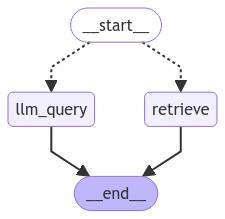

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
# # Step 7: Execute the workflow
# inputs = {
#     "question": "Java"
# }
# for output in app.stream(inputs):
#     for key, value in output.items():
#         print(f"Node '{key}':")
#         print(value)

# Example for querying ML topic
inputs_ml = {
    "question": "Prompt Engineering"
}
for output in app.stream(inputs_ml):
    for key, value in output.items():
        print(f"Node '{key}':")
        print(value)


---ROUTING QUESTION---
---ROUTE TO VECTOR STORE----
---RETRIEVE FROM VECTORSTORE---
Node 'retrieve':
{'question': 'Prompt Engineering', 'generation': AIMessage(content='Here are three questions based on the provided document content:\n\n1. What are the two most basic approaches for prompting a model in the context of autoregressive language models, as discussed in the document?\n\n2. According to the text, what are the potential biases that contribute to high variance in few-shot classification tasks with large language models (LLMs), as identified by Zhao et al. (2021)?\n\n3. What is the primary goal of prompt engineering, according to the document, and what is the main challenge in achieving this goal?', response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 2214, 'total_tokens': 2323, 'completion_time': 0.44356817, 'prompt_time': 0.569919525, 'queue_time': 0.015208591000000049, 'total_time': 1.013487695}, 'model_name': 'llama-3.1-70b-versatile', 'system_finger